In [2]:
# Install a pip package in the current Jupyter kernel
import sys
import os
sys.path.append('../../')
sys.path.append('../../wdtools')
sys.path.append('../../WD_models')
sys.path.append('../../corv/src')


### General
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import astropy
from astropy.coordinates import SkyCoord
from astropy.io import fits
import astropy.units as u
from astropy.table import Table, Column, MaskedColumn, join

from tqdm import tqdm
import pandas as pd
from scipy.optimize import curve_fit
import scipy.stats as stats

### Tools
import wdtools
import WD_models
import data_selector as ds
import WD_models
from bisect import bisect_left
import lmfit
import glob

from astroquery.sdss import SDSS
from astroquery.gaia import Gaia

#corv.sdss.make_catalogs()

In [3]:
c = 2.998e10
k = 1.38e-16
h = 6.626e-27
halpha = 6564.61
hbeta = 4862.68
hgamma = 4341.68
hdelta = 4102.89
speed_light = 299792458 #m/s
radius_sun = 6.957e8
mass_sun = 1.9884e30
newton_G = 6.674e-11
pc_to_m = 3.086775e16

In [4]:
from __future__ import print_function
from astropy.coordinates import SkyCoord
import astropy.units as u
from dustmaps.bayestar import BayestarQuery

coords = SkyCoord('12h30m25.3s', '15d15m58.1s', distance = 200 * u.kpc, frame='icrs')
bsq = BayestarQuery()
ebv = bsq.query(coords)

coords = SkyCoord('12h30m25.3s', '15d15m58.1s', distance = 200 * u.kpc, frame='icrs')
print('E(B-V) = {:.3f} mag'.format(ebv))
#print(ebv)

Loading pixel_info ...
Loading samples ...
Loading best_fit ...
Replacing NaNs in reliable distance estimates ...
Sorting pixel_info ...
Extracting hp_idx_sorted and data_idx at each nside ...
  nside = 64
  nside = 128
  nside = 256
  nside = 512
  nside = 1024
t = 82.188 s
  pix_info:   1.165 s
   samples:  30.827 s
      best:  36.014 s
       nan:   8.435 s
      sort:   5.615 s
       idx:   0.132 s
E(B-V) = 0.040 mag


In [5]:
catalog = Table.read('../data/vedanta/wd_catalog.fits')
falcon = Table.read('../data/falcon2010.fit')


In [7]:
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.table import Table, join_skycoord
from astropy import table

falcon['loc'] = SkyCoord(ra=falcon['_RA'], dec=falcon['_DE'])
catalog['loc'] = SkyCoord(ra=catalog['ra']*u.deg, dec=catalog['dec']*u.deg)

join_func = table.join_skycoord(5 * u.arcsecond)
catalog = table.join(catalog, falcon, join_funcs={'loc': join_skycoord(5 * u.arcsec)})

In [14]:
from astropy.table import unique, Table

catalog = unique(catalog, keys = ['loc_id'])
catalog

loc_id,dist,solution_id,designation,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,parallax_over_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_bad_obs_al,astrometric_gof_al,astrometric_chi2_al,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_params_solved,astrometric_primary_flag,astrometric_weight_al,astrometric_pseudo_colour,astrometric_pseudo_colour_error,mean_varpi_factor_al,astrometric_matched_observations,visibility_periods_used,astrometric_sigma5d_max,frame_rotator_object_type,matched_observations,duplicated_source,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_flux_over_error,phot_g_mean_mag,phot_bp_n_obs,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_bp_mean_flux_over_error,phot_bp_mean_mag,phot_rp_n_obs,phot_rp_mean_flux,phot_rp_mean_flux_error,phot_rp_mean_flux_over_error,phot_rp_mean_mag,phot_bp_rp_excess_factor,phot_proc_mode,bp_rp,bp_g,g_rp,radial_velocity,radial_velocity_error,rv_nb_transits,rv_template_teff,rv_template_logg,rv_template_fe_h,phot_variable_flag,l,b,ecl_lon,ecl_lat,priam_flags,col_p_m_f,ra_dec,sng,u,su,g,sg,r,sr,i,si,z,sz,ebv,ppm,tp,teff,dt,logg,dlogg,vr,dvr,s_n,dt_sp_,d_pc_,z_pc_,mass,dmass,t3d,logg3d,r_est,r_lo,r_hi,r_len,result_flag,modality_flag,loc_1,_Glon,_Glat,_RAJ2000,_DEJ2000,Name,DA,Adp-V,e_Adp-V,Obs,LSR-V,Ha-V,e_Ha-V,Hb-V,e_Hb-V,Obs-V,e_Obs-V,Simbad,_RA,_DE,loc_2
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,"deg,deg",deg,deg,deg,deg,,,km / s,km / s,s,km / s,km / s,km / s,km / s,km / s,km / s,km / s,,deg,deg,"deg,deg"
int64,float64,int64,bytes28,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,float64,float64,float64,float64,int64,bool,float64,float64,float64,float64,int64,int64,float64,int64,int64,bool,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,bytes13,float64,float64,float64,float64,float64,bytes15,bytes19,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes6,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,SkyCoord,float64,float64,float64,float64,bytes13,bytes1,float32,float32,int32,float32,float32,float32,float32,float32,float32,float32,bytes6,float64,float64,SkyCoord
1,7.096823989305173e-05,1635721458409799680,Gaia DR2 588063421770438400,588063421770438400,540068424,2015.5,143.1240964210954,0.09637222396541603,8.44367167355616,0.09797627127047563,8.064776330352142,0.1105098147340384,72.97792,-78.66712031242625,0.19784628481016714,-7.518165419531603,0.16880945543819065,-0.28273353,-0.21625158,-0.14056839,0.37172568,0.40668538,0.30644664,-0.63086617,0.35499802,-0.45895967,-0.058956685999999994,88,0,87,1,0.03639994,81.799644,0.0,0.0,31,False,3.9226160000000005,1.7821762556118126,0.023381731749488845,0.085114226,10,6,0.19424641,0,13,False,109,3584.826453168588,4.660064057643834,769.2655,16.802195,12,2753.786682631138,20.576453614024178,133.83194,16.751562,12,1412.7684502637326,12.619555884625035,111.95073000000001,16.886742,1.1622753000000001,0,-0.13517952,-0.050632477,-0.08454704,1e+20,1e+20,0,1e+20,1e+20,1e+20,NOT_AVAILABLE,224.96069307554126,39.48946070931647,142.68977829952362,-5.819321211592763,100001.0,5314-55952-0464,093229.80+082637.27,49.0,16.936,0.018000000000000002,16.641,0.027999999999999997,16.919,0.013999999999999999,17.171,0.019,1

In [15]:
catalog = catalog[catalog['parallax'] > 0]
coords = [SkyCoord(frame="galactic", l=catalog['l'][i]*u.deg, b=catalog['b'][i]*u.deg, distance = (1000/catalog['parallax'][i]) * u.pc) for i in range(len(catalog))]
catalog['wd_coords'] = coords

In [16]:
catalog['E(B-V)'] = [bsq.query(catalog['wd_coords'][i]) for i in range(len(catalog))]

In [17]:
catalog['err_u'] = catalog['su']
catalog['err_g'] = catalog['sg']
catalog['err_r'] = catalog['sr']
catalog['err_i'] = catalog['si']
catalog['err_z'] = catalog['sz']

In [18]:
catalog['A_u'] = np.repeat(np.nan, len(catalog))
catalog['A_g'] = np.repeat(np.nan, len(catalog))
catalog['A_r'] = np.repeat(np.nan, len(catalog))
catalog['A_i'] = np.repeat(np.nan, len(catalog))
catalog['A_z'] = np.repeat(np.nan, len(catalog))

for obj in tqdm(catalog):
    obj['A_u'] = obj['E(B-V)'] * 3.518
    obj['A_g'] = obj['E(B-V)'] * 2.617
    obj['A_r'] = obj['E(B-V)'] * 1.971
    obj['A_i'] = obj['E(B-V)'] * 1.549
    obj['A_z'] = obj['E(B-V)'] * 1.263
    
catalog['dered_u'] = catalog['u'] - catalog['A_u']
catalog['dered_g'] = catalog['g'] - catalog['A_g']
catalog['dered_r'] = catalog['r'] - catalog['A_r']
catalog['dered_i'] = catalog['i'] - catalog['A_i']
catalog['dered_z'] = catalog['z'] - catalog['A_z']

catalog['r_est'] = 1000 / catalog['parallax']

100%|██████████████████████████████████████████████████████████████████████████| 53/53 [00:00<00:00, 249.19it/s]


In [19]:
font_model = WD_models.load_model('f', 'f', 'f', 'H', HR_bands = ['Su-Sg', 'Su'])

g_acc = (10**font_model['logg'])/100
rsun = np.sqrt(font_model['mass_array'] * mass_sun * newton_G / g_acc) / radius_sun
logg_teff_to_rsun = WD_models.interp_xy_z_func(x = font_model['logg'], y = 10**font_model['logteff'],
                                            z = rsun, interp_type = 'linear')

fitsed = WD_models.FitSED(to_flux = False, atm_type = 'H', bands = ['Su', 'Sg', 'Sr', 'Si', 'Sz'])

initialized with atm_type = H and bands = ['Su', 'Sg', 'Sr', 'Si', 'Sz']


In [20]:
def mag_to_flux(mag):
    return 10 ** ((mag + 48.6)/ -2.5) 
    
def get_model_flux(params):
    
    teff, logg, radius, distance = params['teff'], params['logg'], params['radius'], params['distance']
    
    model_mag = fitsed.model_sed(teff, logg, plx = 100)
    model_flux = mag_to_flux(model_mag)
    
    rsun = logg_teff_to_rsun(logg, teff)
    corr_radius = rsun * radius_sun
    corr_distance = 10 * pc_to_m
    
    corr_model_flux = model_flux / (4 * np.pi * (corr_radius / corr_distance)**2)
    
    radius = radius * radius_sun # Rsun to meter
    distance = distance * pc_to_m # Parsec to meter
     
    flux = corr_model_flux * ( 4 * np.pi * (radius / distance)**2 )
    
    return flux
    

def residual(params, obs_flux = None, e_obs_flux = None):
    model_flux = get_model_flux(params)

    chisquare = ((model_flux - obs_flux) / e_obs_flux)**2
    #chisquare[np.isnan(chisquare)] = 1e8
    return chisquare

In [21]:
def get_parameters(obs_mag, e_obs_mag, id_ = None, floor_error = 0.02, make_plot = False, vary_logg = False, p0 = [10000, 8, 0.01, 100]):      
    obs_flux = mag_to_flux(obs_mag)
    #obs_flux = obs_mag
    
    e_obs_mag = np.sqrt(e_obs_mag**2 + floor_error**2)
    e_obs_flux = e_obs_mag * obs_flux
    
    params = lmfit.Parameters()

    params.add('teff', value = p0[0], min = 3500, max = 55000, vary = True)
    params.add('logg', value = p0[1], min=7.5, max=9, vary=vary_logg)
    params.add('radius', value = p0[2], min = 0.0001, max = 0.05, vary = True)
    params.add('distance', value = p0[3], min = 1, max = 2000, vary = False)
        
    #result = lmfit.minimize(residual, params, kws = dict(obs_flux = obs_flux, e_obs_flux = e_obs_flux), method = 'emcee', steps = 5000, burn = 500, thin = 20, is_weighted = False, progress = False)
    result = lmfit.minimize(residual, params, kws = dict(obs_flux = obs_flux, e_obs_flux = e_obs_flux), method = 'leastsq')
    
    #result.params.pretty_print()
    
    if make_plot:
        bands = ['u', 'g', 'r', 'i', 'z']
        
        
        
        fig = plt.figure(figsize = (8,7))
        plt.errorbar(bands, obs_flux, yerr = e_obs_flux, linestyle = 'none', marker = 'None', color = 'k',
                    capsize = 5, label = 'Observed SED')
        plt.plot(bands, get_model_flux(result.params), 'bo', markersize = 10, label = 'Model SED')
        plt.title('SED {}'.format(id_))
        plt.text(0.15, 0.26, r'$Teff = ${} $K$'.format(result.params['teff'].value), transform = plt.gca().transAxes, fontsize=20)
        plt.xlabel('Band')
        plt.ylabel('Apparent Flux)')
        #plt.gca().invert_yaxis()
        plt.legend() 
        
        return result, fig
    
    return result

In [22]:
results = []
results7 = []
results9 = []
e_results = []

plots = []

logg_vary = []

for i in tqdm(range(len(catalog))):
    obs_mag = np.array([catalog['u'][i] - 0.040, catalog['g'][i], catalog['r'][i], catalog['i'][i] + 0.015, catalog['z'][i] + 0.030])
    e_obs_mag = np.array([catalog['err_u'][i], catalog['err_g'][i], catalog['err_r'][i], catalog['err_i'][i], catalog['err_z'][i]])
    
    logg7 = get_parameters(obs_mag, e_obs_mag, id_ = 0, vary_logg=False, p0 = [10000, 7, 0.003, catalog['r_est'][i]] )
    logg8 = get_parameters(obs_mag, e_obs_mag, id_ = 0, vary_logg=False, p0 = [10000, 8, 0.003, catalog['r_est'][i]], make_plot = False )
    logg9 = get_parameters(obs_mag, e_obs_mag, id_ = 0, vary_logg=False, p0 = [10000, 9, 0.003, catalog['r_est'][i]] )
    
    #plots.append(plot)
    
    results.append(logg8)
    results7.append(logg7)
    results9.append(logg9)
    logg_vary.append(get_parameters(obs_mag, e_obs_mag, vary_logg = True, p0 = [10000, 8, 0.01, catalog['r_est'][i]]))

100%|███████████████████████████████████████████████████████████████████████████| 53/53 [00:04<00:00, 12.24it/s]


In [23]:
vary_catalog = catalog.copy()

catalog['radius2'] = [result.params['radius'].value for result in results]
catalog['phot_teff'] = [result.params['teff'].value for result in results]
catalog['e_phot_teff'] = [result.params['teff'].stderr for result in results]
catalog['redchi'] = [result.redchi for result in results]
catalog['e_radius'] = [np.sqrt(results[i].params['radius'].stderr**2 + np.abs(results7[i].params['radius'].value - results9[i].params['radius'].value)**2 ) for i in range(len(results))]
catalog['error_from_model'] = [np.abs(results7[i].params['radius'].value - results9[i].params['radius'].value) for i in range(len(results))]

vary_catalog['radius'] = [result.params['radius'].value for result in logg_vary]
vary_catalog['teff'] = [result.params['teff'].value for result in logg_vary]
vary_catalog['e_teff'] = [result.params['teff'].stderr for result in logg_vary]
vary_catalog['redchi'] = [result.redchi for result in logg_vary]
vary_catalog['e_radius'] = [result.params['radius'].stderr for result in logg_vary]

Text(0.5, 0, 'Photometric Radius $[R_{0}]$')

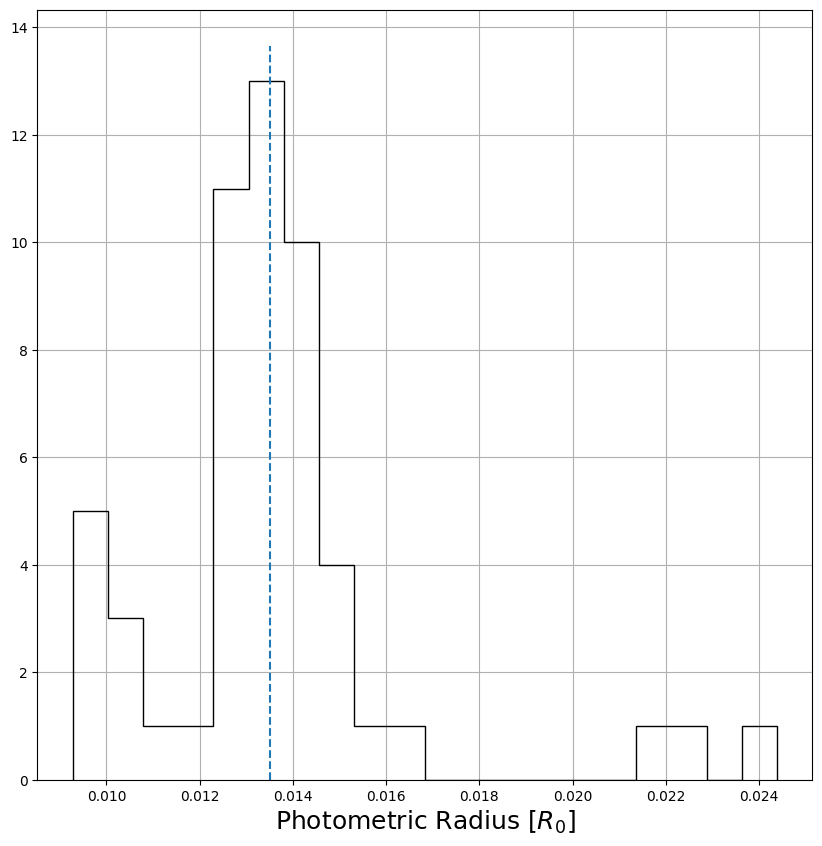

In [26]:
plt.figure(figsize=(10,10))
plt.grid()
plt.hist(catalog['radius2'], bins = 20, histtype='step', color='black')
ymin, ymax = plt.ylim()
plt.vlines(np.mean(catalog['radius2']), ymin, ymax, linestyles='dashed')
plt.xlabel(r'Photometric Radius $[R_{0}]$', fontsize=18)


In [31]:
model = WD_models.load_model('f', 'f', 'f', 'H')
font_model = model

def rv_from_radius(radarray, teffarray, lowmass = 'f', midmass = 'f', highmass = 'f'):
    
    if lowmass is not 'f' or highmass is not 'f' or midmass is not 'f':
        font_model = WD_models.load_model(lowmass, midmass, highmass, 'H')
    else:
        font_model = model

    #     font_model = WD_models.load_model(lowmass, midmass, highmass, 'H')


    g_acc = (10**font_model['logg'])/100
    rsun = np.sqrt(font_model['mass_array'] * mass_sun * newton_G / g_acc) / radius_sun
    
    rsun_teff_to_m = WD_models.interp_xy_z_func(x = rsun, y = 10**font_model['logteff'],\
                                                z = font_model['mass_array'], interp_type = 'linear')
    
    mass = rsun_teff_to_m(radarray, teffarray) * mass_sun
    radius = radarray * radius_sun
    rv = newton_G * mass / (speed_light * radius)

    return rv*1e-3

<>:6: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:6: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:6: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:6: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:6: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:6: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/tmp/ipykernel_6351/2006706867.py:6: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if lowmass is not 'f' or highmass is not 'f' or midmass is not 'f':
/tmp/ipykernel_6351/2006706867.py:6: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if lowmass is not 'f' or highmass is not 'f' or midmass is not 'f':
/tmp/ipykernel_6351/2006706867.py:6: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if lowmass is not 'f' or highmass is not 'f' or midmass is not 'f':


In [32]:
print(catalog.keys())

['loc_id', 'dist', 'solution_id', 'designation', 'source_id', 'random_index', 'ref_epoch', 'ra', 'ra_error', 'dec', 'dec_error', 'parallax', 'parallax_error', 'parallax_over_error', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'ra_dec_corr', 'ra_parallax_corr', 'ra_pmra_corr', 'ra_pmdec_corr', 'dec_parallax_corr', 'dec_pmra_corr', 'dec_pmdec_corr', 'parallax_pmra_corr', 'parallax_pmdec_corr', 'pmra_pmdec_corr', 'astrometric_n_obs_al', 'astrometric_n_obs_ac', 'astrometric_n_good_obs_al', 'astrometric_n_bad_obs_al', 'astrometric_gof_al', 'astrometric_chi2_al', 'astrometric_excess_noise', 'astrometric_excess_noise_sig', 'astrometric_params_solved', 'astrometric_primary_flag', 'astrometric_weight_al', 'astrometric_pseudo_colour', 'astrometric_pseudo_colour_error', 'mean_varpi_factor_al', 'astrometric_matched_observations', 'visibility_periods_used', 'astrometric_sigma5d_max', 'frame_rotator_object_type', 'matched_observations', 'duplicated_source', 'phot_g_n_obs', 'phot_g_mean_flux', 'pho

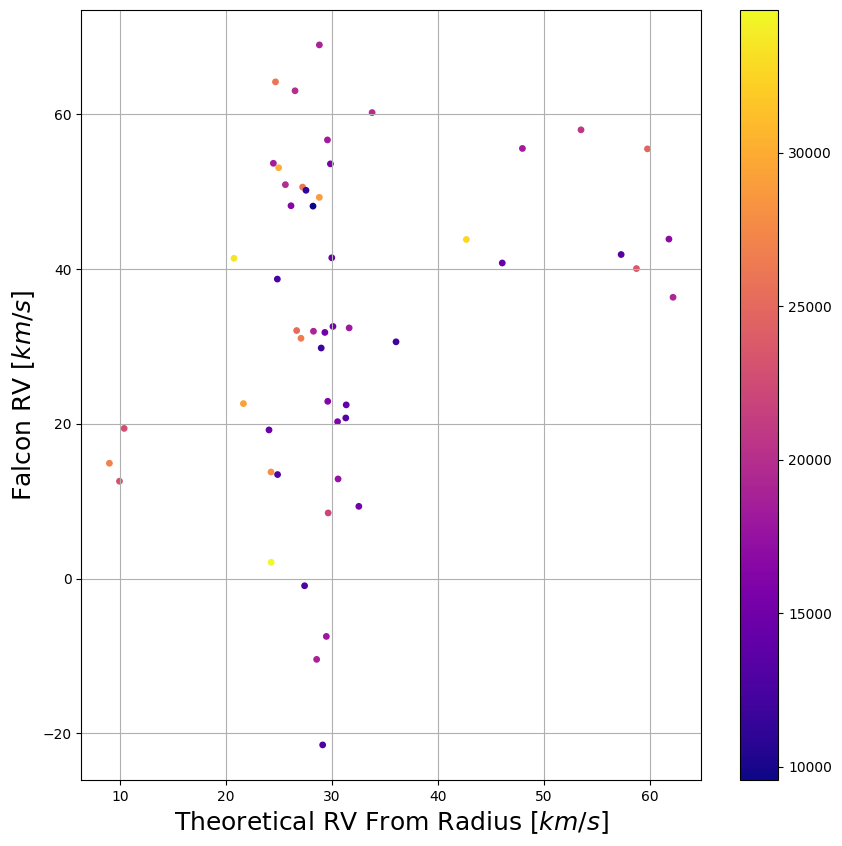

In [42]:
import scipy.stats as stats

def linear(x):
    return x

temp_catalog = catalog#[np.abs(stats.zscore(catalog['vr'])) < 1].copy()

plt.figure(figsize=(10,10))
plt.grid()
plt.scatter(rv_from_radius(catalog['radius2'], catalog['teff']), catalog['Adp-V'], c = catalog['teff'], s=15, cmap='plasma')
#plt.plot(rv_from_radius(catalog['radius2'], catalog['teff']), linear(rv_from_radius(catalog['radius2'], catalog['teff'])))
ymin, ymax = plt.ylim()
plt.xlabel(r'Theoretical RV From Radius $[km/s]$', fontsize=18)
plt.ylabel(r'Falcon RV $[km/s]$', fontsize=18)
plt.colorbar()

Text(0, 0.5, 'Falcon RV $[km/s]$')

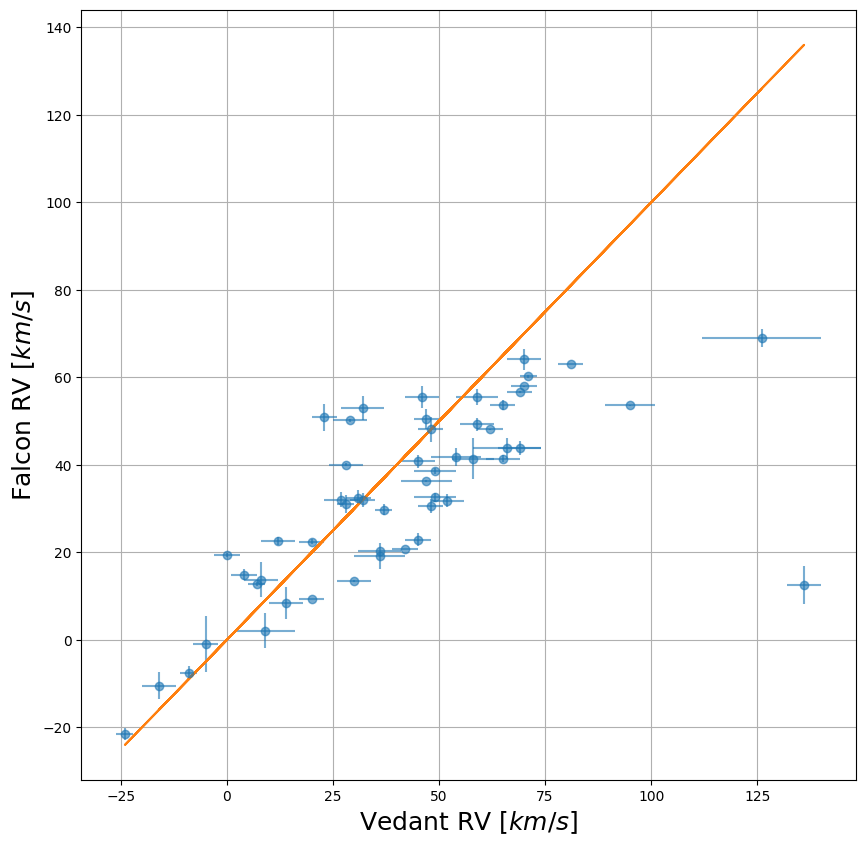

In [39]:
import scipy.stats as stats

def linear(x):
    return x

temp_catalog = catalog#[np.abs(stats.zscore(catalog['vr'])) < 1].copy()

plt.figure(figsize=(10,10))
plt.grid()

plt.errorbar(catalog['vr'], catalog['Adp-V'], xerr = catalog['dvr'], yerr = catalog['e_Adp-V'], fmt='o', alpha = 0.6)
plt.plot(catalog['vr'], linear(catalog['vr']))


ymin, ymax = plt.ylim()
plt.xlabel(r'Vedant RV $[km/s]$', fontsize=18)
plt.ylabel(r'Falcon RV $[km/s]$', fontsize=18)
#plt.colorbar()